# MNIST Task

This notebook contains the main results for the MNIST task, presented as Figure 6 in the paper.

## Setup

In [7]:
import random as rn
rn.seed(2019)

import numpy as np
np.random.seed(2019)

import tensorflow as tf
tf.set_random_seed(2019)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
#                               inter_op_parallelism_threads=1)
from keras import backend as K

# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append("../../../neurophox")

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.utils import to_categorical

from keras.datasets import mnist

from neurophox.keras import RD, CGRD
from neurophox.helpers import np_to_k_complex, tf_to_k_complex, k_to_tf_complex, k_complex_from_real, k_real, k_imag

from utils_tf_mnist import *
from utils_tf_plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and process data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Get and set parameters
N_train = x_train.shape[0]
N_test  = x_test.shape[0]
m_image = x_train.shape[1]
n_image = x_train.shape[2]
N_classes = 10
N = m_image * n_image

# which training examples to keep
N_train_keep = 60000
N_test_keep = 10000

ind_train_keep =  np.arange(N_train)
ind_test_keep =  np.arange(N_test)
np.random.shuffle(ind_train_keep)
np.random.shuffle(ind_test_keep)
ind_train_keep = ind_train_keep[:N_train_keep]
ind_test_keep = ind_test_keep[:N_test_keep]

# take the fourier transform
x_train_ft = np.fft.fft2(x_train)
x_test_ft = np.fft.fft2(x_test)

# flatten and one-hotify and keep only random sample
x_train_ft_flattened = x_train_ft.reshape((N_train, N))[ind_train_keep, :]
x_test_ft_flattened = x_test_ft.reshape((N_test, N))[ind_test_keep, :]
y_train_onehot = np.array([value_to_one_hot(y, N_classes) for y in y_train])[ind_train_keep, :]
y_test_onehot = np.array([value_to_one_hot(y, N_classes) for y in y_test])[ind_test_keep, :]

# select which FT components to keep
ft_inds = np.hstack((np.arange(0, 3), np.arange(28, 31), np.arange(54, 59), np.arange(82,86), 4*28-1))
N = ft_inds.shape[0] # new size of the training data
print('Taking {} Fourier components'.format(N))

# Take only those FT components
x_train_ft = x_train_ft_flattened[:, ft_inds]
x_test_ft = x_test_ft_flattened[:, ft_inds]

# normalize x
x_train_norm = x_train_ft / np.linalg.norm(x_train_ft, ord=2, axis=1)[:,None]
x_test_norm  = x_test_ft / np.linalg.norm(x_test_ft, ord=2, axis=1)[:,None]

Taking 16 Fourier components


## Set optimization parameters

For consistency, we set the training parameters to be used in the models below.

In [3]:
epochs = 200
batch_size = 500

---

## **ONN without activation (linear)**

In [12]:
L_lin = 1
model_lin = construct_onn_linear_tf(N,
                                    L=L_lin,
                                    theta_initializer='haar',
                                    phi_initializer='random_phi')

def loss(y_true, y_pred):
    y_pred = y_pred/y_pred.sum()
    return K.categorical_crossentropy(y_true, y_pred, from_logits=False)


model_lin.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_lin = model_lin.fit(np_to_k_complex(x_train_norm),
                            y_train_onehot,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(np_to_k_complex(x_test_norm), y_test_onehot),
                            verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
 - 5s - loss: 2.4281 - acc: 0.1573 - val_loss: 1.9898 - val_acc: 0.2680
Epoch 2/200
 - 3s - loss: 1.8048 - acc: 0.3624 - val_loss: 1.6429 - val_acc: 0.4814
Epoch 3/200
 - 3s - loss: 1.5718 - acc: 0.5357 - val_loss: 1.4887 - val_acc: 0.6121
Epoch 4/200
 - 3s - loss: 1.4502 - acc: 0.6284 - val_loss: 1.3898 - val_acc: 0.6807
Epoch 5/200
 - 3s - loss: 1.3644 - acc: 0.6857 - val_loss: 1.3165 - val_acc: 0.7218
Epoch 6/200
 - 4s - loss: 1.3024 - acc: 0.7200 - val_loss: 1.2640 - val_acc: 0.7448
Epoch 7/200
 - 3s - loss: 1.2588 - acc: 0.7400 - val_loss: 1.2267 - val_acc: 0.7599
Epoch 8/200
 - 3s - loss: 1.2246 - acc: 0.7530 - val_loss: 1.1972 - val_acc: 0.7657
Epoch 9/200
 - 3s - loss: 1.1979 - acc: 0.7610 - val_loss: 1.1724 - val_acc: 0.7737
Epoch 10/200
 - 3s - loss: 1.1764 - acc: 0.7672 - val_loss: 1.1536 - val_acc: 0.7798
Epoch 11/200
 - 3s - loss: 1.1589 - acc: 0.7729 - val_loss: 1.1383 - val_acc: 0.7819
Epoch 12/200
 - 3s - los

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vcrd_4 (VCRD)                multiple                  256       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
lambda_3 (Lambda)            multiple                  0         
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________
Acc = 0.8466


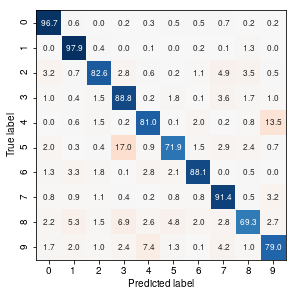

In [13]:
model_lin.summary()
cf_matrix = calc_confusion_matrix_tf(model_lin, x_test_norm, y_test_onehot)
fig = plot_confusion_matrix(cf_matrix);
# fig.savefig("../../../docs/figures/scratch/result_mnist_cm_lin.svg")

---

## **ONN with activation**

The EO parameters here are **fixed**.


### ReLU-like configuration
* Works up to 3 layers then produces nan loss function
* Difficult to optimize

In [4]:
L_eo = 2
eo_params = {"alpha": 0.10,
             "g":     0.05*np.pi,
             "phi_b": 1.00*np.pi }

In [5]:
model_eo = construct_onn_EO_tf(N,
                               L=L_eo,
                               train_alpha=False,
                               train_g=False,
                               train_phi_b=False,
                               single_param_per_layer=True,
                               theta_initializer='haar',
                               phi_initializer='random_phi',
                               **eo_params)

model_eo.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_eo = model_eo.fit(np_to_k_complex(x_train_norm),
                          y_train_onehot,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(np_to_k_complex(x_test_norm), y_test_onehot),
                          verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 10s - loss: 1.9574 - acc: 0.4402 - val_loss: 1.1966 - val_acc: 0.6338
Epoch 2/200
 - 7s - loss: 1.0331 - acc: 0.6881 - val_loss: 0.8757 - val_acc: 0.7456
Epoch 3/200
 - 7s - loss: 0.8142 - acc: 0.7645 - val_loss: 0.7297 - val_acc: 0.7968
Epoch 4/200
 - 7s - loss: 0.7062 - acc: 0.8025 - val_loss: 0.6480 - val_acc: 0.8235
Epoch 5/200
 - 8s - loss: 0.6393 - acc: 0.8244 - val_loss: 0.5942 - val_acc: 0.8447
Epoch 6/200
 - 8s - loss: 0.5943 - acc: 0.8394 - val_loss: 0.5550 - val_acc: 0.8546
Epoch 7/200
 - 8s - loss: 0.5583 - acc: 0.8515 - val_loss: 0.5233 - val_acc: 0.8650
Epoch 8/200
 - 8s - loss: 0.5300 - acc: 0.8595 - val_loss: 0.4970 - val_acc: 0.8727
Epoch 9/200
 - 8s - loss: 0.5075 - acc: 0.8673 - val_loss: 0.4783 - val_acc: 0.8752
Epoch 10/200
 - 9s - loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vcrd (VCRD)                  multiple                  256       
_________________________________________________________________
eo_intensity_modulation (EOI multiple                  3         
_________________________________________________________________
vcrd_1 (VCRD)                multiple                  256       
_________________________________________________________________
eo_intensity_modulation_1 (E multiple                  3         
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 518
Trainable params: 512
Non-trainable params: 6
_________________________________________________________________
Acc = 0.9242

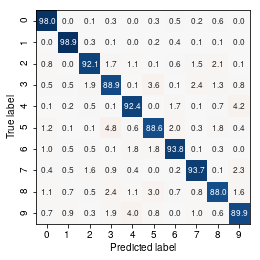

In [9]:
model_eo.summary()
cf_matrix = calc_confusion_matrix_tf(model_eo, x_test_norm, y_test_onehot)
fig = plot_confusion_matrix(cf_matrix, figsize=(3.5,3.5));
fig.savefig("result_mnist_cm_eo.svg")

---

## **Comparison:** Linear and EO

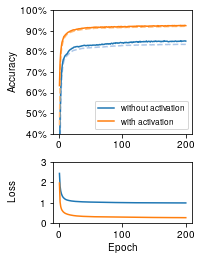

In [25]:
fig,axs = plot_model_comparison((history_lin,
                             history_eo), 
                            ("without activation", "with activation"),
                            figsize=(2.7, 3.5),
                            height_ratios=([1,0.5]));
axs[1].set_yticks(np.linspace(0,3,4))
fig.align_labels()
fig.savefig("result_mnist_comparison.svg")

---

## **Model 3:** ONN with *trained* EO

Here we allow the training algorithm to also optimize the parameters $\alpha$, $g$, and $\phi_b$ at each activation block. Which of these parameters we train depends on the values for `train_alpha`, `train_g`, and `train_phi_b`. Note that we are going to use the option `single_param_per_layer=True`, which means that a single value of $\alpha$, $g$, and $\phi_b$ are used at each layer, rather than allowing them to be defined row-wise.

### Notes
I've observed that the initialization of the activaton (which is uniform and specified by `eo_params_init`) will strongly influence the quality of the training.

### **Config:** activation - Saturation and clipping
* Appears to be close to optimal for this $\phi_b$

In [77]:
L_eo_t = 4
eo_params = {"alpha": 0.10,
             "g":     np.array([0.05, 0.05, 0.05, 0.05])*np.pi,
             "phi_b": np.array([1.00, 0.00, 1.00, 0.00])*np.pi }

In [ ]:
model_eo_t = construct_onn_EO_tf(N,
                                 L=L_eo_t,
                                 train_alpha=False,
                                 train_g=True,
                                 train_phi_b=False,
                                 single_param_per_layer=False,
                                 theta_initializer='haar',
                                 phi_initializer='random_phi',
                                 **eo_params)

model_eo_t.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

history_eo_t = model_eo_t.fit(np_to_k_complex(x_train_norm),
                              y_train_onehot,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(np_to_k_complex(x_test_norm), y_test_onehot),
                              verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vcrd_24 (VCRD)               multiple                  256       
_________________________________________________________________
eo_intensity_modulation_165  multiple                  48        
_________________________________________________________________
vcrd_25 (VCRD)               multiple                  256       
_________________________________________________________________
eo_intensity_modulation_166  multiple                  48        
_________________________________________________________________
vcrd_26 (VCRD)               multiple                  256       
_________________________________________________________________
eo_intensity_modulation_167  multiple                  48        
_________________________________________________________________
vcrd_27 (VCRD)               multiple                  256       
__________

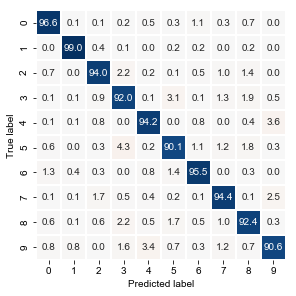

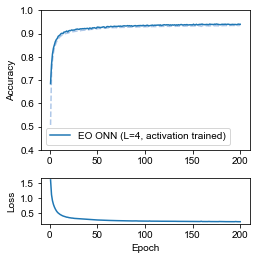

In [80]:
model_eo_t.summary()
cf_matrix = calc_confusion_matrix_tf(model_eo_t, x_test_norm, y_test_onehot)
plot_confusion_matrix(cf_matrix);

fig = plot_model_comparison((history_eo_t,), ("EO ONN (L=%d, activation trained)" % L_eo_t,));